In [1]:
import os
from datetime import datetime

import haversine as hs
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [2]:
# Data paths
train_data_path = os.getcwd() + "/../datasets/202203-capitalbikeshare-tripdata.csv"
validation_data_path = os.getcwd() + "/../datasets/202204-capitalbikeshare-tripdata.csv"
testing_data_path = os.getcwd() + "/../datasets/202205-capitalbikeshare-tripdata.csv"

In [5]:
# Read and process data

# Distance calculation method
def get_distance_kilometres(start_lat, start_lon, end_lat, end_lon):
    """Calculate distance in kilometres"""

    start_loc=(start_lat, start_lon)
    end_loc=(end_lat, end_lon)
    return hs.haversine(start_loc, end_loc, unit=hs.Unit.KILOMETERS)

# Process data
def process_data(df):
    """Creating new features"""


    data = df.copy()
    date_fields = ["started_at", "ended_at"]
    for cols in date_fields:
        if data[cols].dtype == 'O': 
            data[cols] = [datetime.strptime(val, '%Y-%m-%d %H:%M:%S') for val in data[cols]]
    data["duration"] = (data["ended_at"] - data["started_at"]).apply(lambda x: x.total_seconds()/60)
    data = data[(data["duration"] > 0) & (data["duration"] <= 120)].dropna(axis=0).copy()
    data["distance"] = [get_distance_kilometres(start_lat, start_lng, end_lat, end_lng)
                        for start_lat, start_lng, end_lat, end_lng in 
                        zip(data["start_lat"], data["start_lng"], data["end_lat"], data["end_lng"])]
    data["SL_EL"] = data["start_station_id"].astype(int).astype(str) + "_" + data["end_station_id"].astype(int).astype(str)
    data["start_hour"] = data["started_at"].dt.hour
    data["day_of_week"] = data["started_at"].dt.day_name()
    return data


# Read and processing

def read_and_process(filepath: str="") -> pd.DataFrame:
    """Function to read and process data"""

    data = pd.read_csv(filepath_or_buffer=filepath)
    processed_data = process_data(data)

    return processed_data



In [6]:
# Training , validation and testing processed data
train_data = read_and_process(filepath=train_data_path)
valid_data = read_and_process(filepath=validation_data_path)
test_data = read_and_process(filepath=testing_data_path)

In [12]:
# Feature and target
feature_cols = ["rideable_type", "distance", "member_casual", "SL_EL", "day_of_week", "start_hour"]
target = "duration"

# Training data
X_train = train_data[feature_cols]
y_train = train_data[target]

# Validation data

X_val = valid_data[feature_cols]
y_val = valid_data[target]

# Testing data
X_test = test_data[feature_cols]
y_test = test_data[target]

In [13]:
# Creating sklearn pipeline
pipeline = Pipeline(
    steps=[
        ("dict_vectorizor", DictVectorizer()),
        ("scaler", StandardScaler(with_mean=False)),
        ("estimator", RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1))
    ]
)

In [14]:
# Running the model pipeline 
pipeline.fit(X_train.to_dict(orient="records"), y_train)
predict_val = pipeline.predict(X_val.to_dict(orient="records"))
predict_test = pipeline.predict(X_test.to_dict(orient="records"))

In [15]:
# Calculating the validation and testing error
rmse_val = mean_squared_error(y_val, predict_val, squared=False)
rmse_test = mean_squared_error(y_test, predict_test, squared=False)

In [16]:
# Printing the root mean square error results
print(rmse_val, rmse_test)

16.273487587406777 15.923531848861435


(array([2.5280e+03, 4.2590e+03, 1.0083e+04, 1.6820e+04, 2.0278e+04,
        2.0671e+04, 2.0870e+04, 2.0993e+04, 1.9308e+04, 1.7990e+04,
        1.6694e+04, 1.5085e+04, 1.2740e+04, 1.1290e+04, 1.0343e+04,
        9.3320e+03, 8.3670e+03, 7.0970e+03, 6.2390e+03, 5.5560e+03,
        5.1480e+03, 4.3530e+03, 3.9640e+03, 3.5020e+03, 3.1530e+03,
        2.8410e+03, 2.3930e+03, 2.1080e+03, 1.8450e+03, 1.5820e+03,
        1.4810e+03, 1.3660e+03, 1.2660e+03, 1.1800e+03, 9.8200e+02,
        9.1500e+02, 7.6300e+02, 8.1000e+02, 6.7200e+02, 5.8800e+02,
        5.7300e+02, 4.7000e+02, 5.0000e+02, 5.2700e+02, 4.5900e+02,
        4.2400e+02, 4.5900e+02, 3.7000e+02, 2.9800e+02, 2.8500e+02,
        3.1300e+02, 2.6300e+02, 2.2900e+02, 2.2100e+02, 2.2200e+02,
        2.2500e+02, 1.7300e+02, 1.5900e+02, 1.5600e+02, 1.7200e+02,
        1.6700e+02, 1.4400e+02, 1.0400e+02, 1.4100e+02, 8.3000e+01,
        1.0900e+02, 8.1000e+01, 1.1700e+02, 7.7000e+01, 6.0000e+01,
        7.5000e+01, 7.1000e+01, 7.0000e+01, 5.70

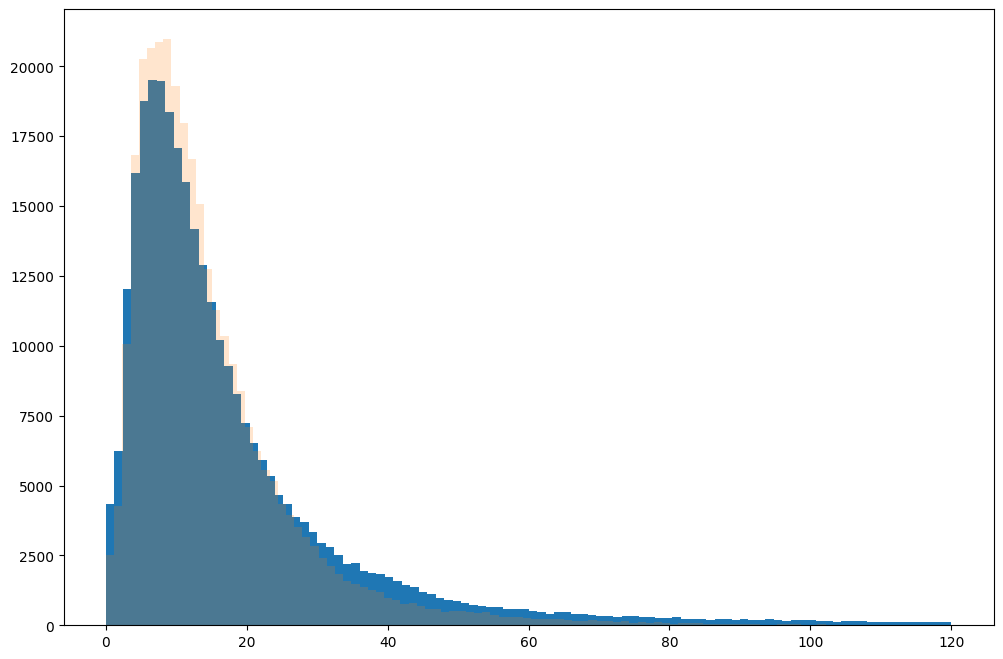

In [17]:
# Plotting the results
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(y_test, bins=100, label="Actual")
ax.hist(predict_test, bins=100, alpha=0.2, label="Predicted")